# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Importar Librerias y DF

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

In [167]:
df = pd.read_csv('datasets/taxi.csv', parse_dates=[0])
print(df.head())
print(df.tail())

             datetime  num_orders
0 2018-03-01 00:00:00           9
1 2018-03-01 00:10:00          14
2 2018-03-01 00:20:00          28
3 2018-03-01 00:30:00          20
4 2018-03-01 00:40:00          32
                 datetime  num_orders
26491 2018-08-31 23:10:00          32
26492 2018-08-31 23:20:00          24
26493 2018-08-31 23:30:00          27
26494 2018-08-31 23:40:00          39
26495 2018-08-31 23:50:00          53


In [168]:
# Nos aseguramos de quitar valores duplicados o ausentes

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

Los datos estan en orden cronologico: True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


<Axes: xlabel='datetime'>

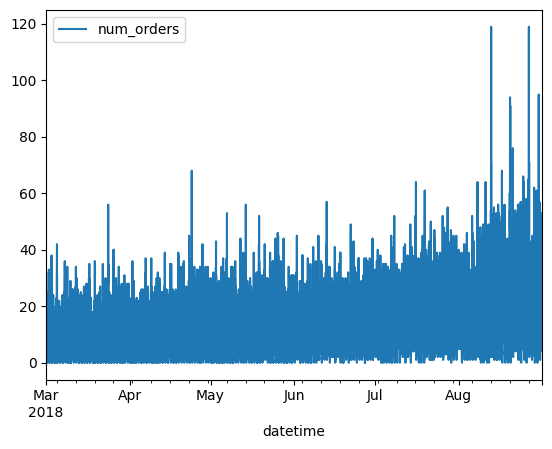

In [169]:
# Paso mis fechas a mi indice
df.set_index('datetime',inplace=True)

# Imprimo si esta en orden cronologico y la info de mi df
print(f'Los datos estan en orden cronologico: {df.index.is_monotonic_increasing}')
print(df.info())

# Trazo el gráfico
df.plot()

Podemos ver que tenemos dos columnas, la fecha y el numero de ordenes, por como esta el df de head podemos decir que tenemos datos cada 10 minutos. Ya viene con un sort por fecha, las fechas estan en formato de object, 'yyyy-mm-dd'. Las ordenes abarcan del 01 de Marzo 2018 al 31 de Agosto 2018.

### Remuestreo

Los datos se encuentran en intervalos de 10 minutos, el primer paso sera agruparlos por hora como se indica en el proyecto. Para esto haremos un resampling por hora y una sumatoria. Si usaramos mean me daria el promedio de pedidos cada 10 minutos en una hora. En este caso buscamos la cantidad total de pedidos de taxi por hora.

In [170]:
# Remuestreo por hora y sumamos todos los pedidos de cada hora.
df = df.resample('1h').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


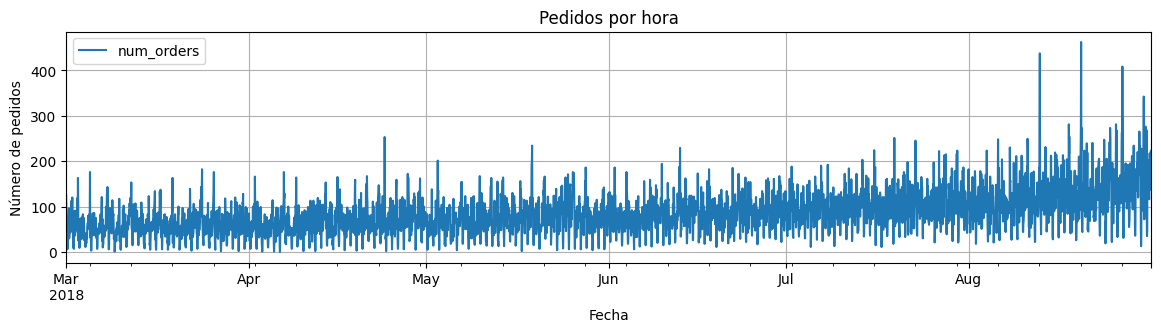

In [171]:
df.plot(figsize=(14, 3), title='Pedidos por hora')
plt.ylabel("Número de pedidos")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

## Análisis

### Media Movil

Obtenemos la media movil a lo largo de 6 horas, asi obtenemos 4 secciones por dia y amortiguamos las fluctuaciones pero manteniendo un buen nivel de precisión para los modelos. Usaremos una quincena al azar para visualizar mejor el conjunto.

<Axes: xlabel='datetime'>

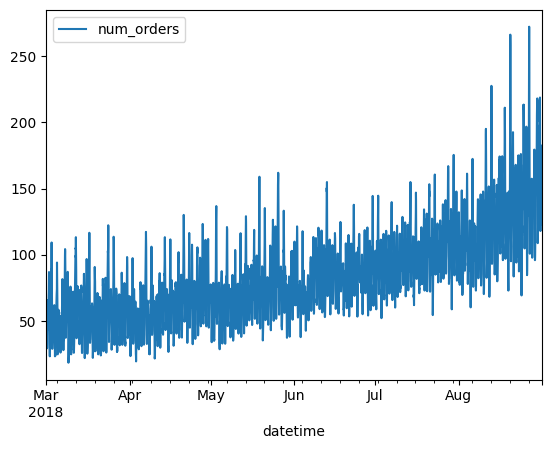

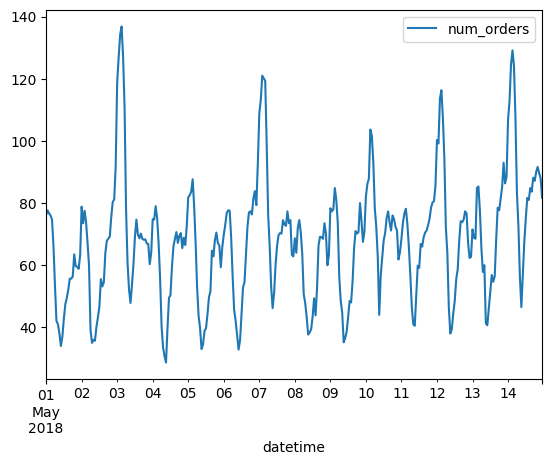

In [172]:
df.rolling(6).mean().plot()
df.rolling(6).mean()["2018-05-01":"2018-05-14"].plot()

### Seasonal Decompose

Buscamos separar la serie en tendencia, estacionalidad y residuo.

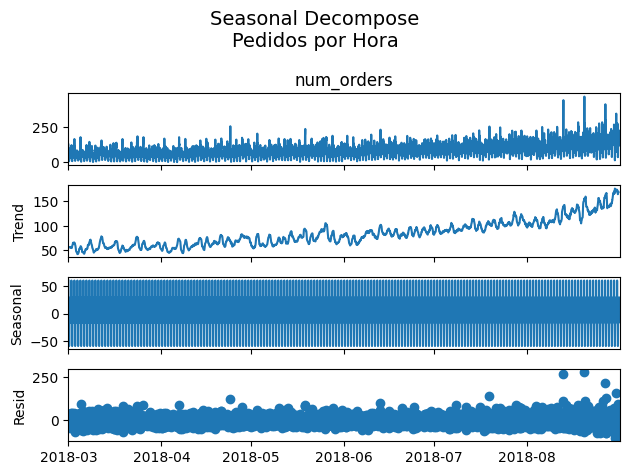

In [173]:
decomposed = seasonal_decompose(df['num_orders'], model='additive', period=24)
decomposed.plot()
plt.suptitle('Seasonal Decompose\nPedidos por Hora', fontsize=14)
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime'>

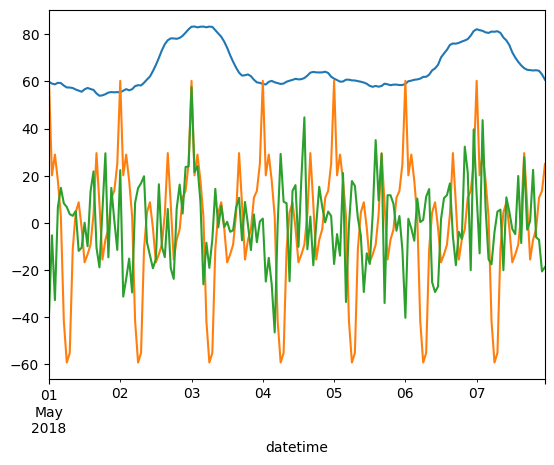

In [174]:
# Seasonal Decompose viendo la quincena aleatoria

decomposed.trend["2018-05-01":"2018-05-07"].plot()
decomposed.seasonal["2018-05-01":"2018-05-07"].plot()
decomposed.resid["2018-05-01":"2018-05-07"].plot()

De nuestros graficos podemos ver que:

- Empieza a haber una tendencia a la alza, empezando a ser mas notoria a partir del mes de Agosto.
- La estacionalidad desaparece a largo plazo.
- Dentro de un dia podemos ver horas pico y horas de baja demanda.

## Formación

Función para creaciond e caracteristicas año, mes, dia y dia de la semana.

* En este caso, no incluiremos año debido a que no agrega variabilidad, debido a que todos nuestros valores de año son 2018.

In [176]:
def make_features(df, max_lag, rolling_mean_size):
    df.dropna(inplace=True)
    
    #df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df["rolling_mean"]=df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Corremos nuestra funcion seleccionando un max lag de 4 y rolling mean de 4 arbitrariamente.

In [177]:
make_features(df, 4, 4)
df = df.dropna()
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,86.50
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,66.25
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,46.50
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,31.75
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,19.00


In [181]:
df.corr()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
num_orders,1.000000,0.510724,0.165613,-0.019631,0.004426,0.624188,0.465559,0.321289,0.248791,0.518818
month,0.510724,1.000000,0.003218,-0.011978,-0.001919,0.510694,0.510415,0.510187,0.509330,0.637717
day,0.165613,0.003218,1.000000,-0.013848,-0.002200,0.165602,0.165521,0.165036,0.164691,0.206523
dayofweek,-0.019631,-0.011978,-0.013848,1.000000,-0.000004,-0.027334,-0.029569,-0.029058,-0.028695,-0.035831
hour,0.004426,-0.001919,-0.002200,-0.000004,1.000000,-0.075944,-0.120203,-0.154571,-0.146248,-0.155285
lag_1,0.624188,0.510694,0.165602,-0.027334,-0.075944,1.000000,0.623505,0.465064,0.320580,0.753074
lag_2,0.465559,0.510415,0.165521,-0.029569,-0.120203,0.623505,1.000000,0.623204,0.464503,0.847302
lag_3,0.321289,0.510187,0.165036,-0.029058,-0.154571,0.465064,0.623204,1.000000,0.622932,0.847185
lag_4,0.248791,0.509330,0.164691,-0.028695,-0.146248,0.320580,0.464503,0.622932,1.000000,0.752372
rolling_mean,0.518818,0.637717,0.206523,-0.035831,-0.155285,0.753074,0.847302,0.847185,0.752372,1.000000


### Train Test Split

In [193]:
df

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,86.50
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,66.25
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,46.50
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,31.75
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,19.00
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,184.25
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,189.25
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,178.50


In [201]:
# Aplicamos un train_test
X = df.drop(columns='num_orders')
y = df['num_orders']

# Train test Split con 75% train y 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Regresión Lineal

In [202]:
# Pipeline con modelo y scaler
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Entrenamos el modelo y medimos el tiempo
pipeline.fit(X_train, y_train)

# Hacemos predicciones
y_pred = pipeline.predict(X_test)

# Calculamos RMSE
rmse = root_mean_squared_error(y_test, y_pred)

# 5. Mostramos resultados
print(f"RMSE en conjunto de prueba: {rmse:.2f}")

RMSE en conjunto de prueba: 33.63


### Arbol de Decision

In [205]:
# Scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Hiperparámetros
param_grid = {
    'model__max_depth': [5, 10, 15, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Evaluación
y_pred = grid_search.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred)

# Resultados
print(f"Mejor RMSE (negativo): {grid_search.best_score_:.2f}")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"RMSE en conjunto de prueba: {rmse_test:.2f}")

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Mejor RMSE (negativo): -30.31
Mejores parámetros: {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
RMSE en conjunto de prueba: 30.36


### Random Forest

In [206]:
# Scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Pipeline con escalado + modelo
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grid de hiperparámetros para RandomForest
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
grid_search_rf.fit(X_train, y_train)

# Evaluación
y_pred_rf = grid_search_rf.predict(X_test)
rmse_test_rf = root_mean_squared_error(y_test, y_pred_rf)

# Resultados
print(f"Mejor RMSE (negativo): {grid_search_rf.best_score_:.2f}")
print(f"Mejores parámetros: {grid_search_rf.best_params_}")
print(f"RMSE en conjunto de prueba: {rmse_test_rf:.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejor RMSE (negativo): -25.47
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
RMSE en conjunto de prueba: 26.35


### XGBoost

In [208]:
# Scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Pipeline con escalado y modelo
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Grid de hiperparámetros
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento
grid_search_xgb.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_xgb = grid_search_xgb.predict(X_test)
rmse_test_xgb = root_mean_squared_error(y_test, y_pred_xgb)

# Resultados
print(f"Mejor RMSE (negativo): {grid_search_xgb.best_score_:.2f}")
print(f"Mejores parámetros: {grid_search_xgb.best_params_}")
print(f"RMSE en conjunto de prueba: {rmse_test_xgb:.2f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejor RMSE (negativo): -24.11
Mejores parámetros: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
RMSE en conjunto de prueba: 24.62


## Prueba

In [223]:
# Diccionario con resultados
model_results = {
    'Modelo': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse, rmse_test, rmse_test_rf, rmse_test_xgb]
}

# Crear DataFrame
df_resultados = pd.DataFrame(model_results)
df_resultados.sort_values(by='RMSE').set_index('Modelo')

,RMSE
Modelo,
XGBoost,24.619785
Random Forest,26.347172
Decision Tree,30.362524
Linear Regression,33.632503


El modelo XGBoost es el que nos da el RMSE mas bajo con un resultado de 24.62.

XGBoost es la opción recomendada para ser implementada en producción, ya que ofrece una excelente relación entre precisión y eficiencia. Además, al tratarse de un modelo robusto frente a datos ruidosos y capaz de capturar relaciones no lineales, se adapta bien a problemas de series de tiempo como este.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48